# auto_annot_Martin2019_with_Smillie2019_Type

In [1]:
import besca as bc
import scanpy as sc
import pkg_resources

### Specify folders where .h5ad files are found and their names. 

The datasets that are already annotated and should be used for training. If you only use one dataset please use list of one.

In [2]:
adata_trains = [sc.read(pkg_resources.resource_filename('besca', 'datasets/data/Smillie2019_processed.h5ad'))]

The dataset of interest that should be annotated.

In [3]:
adata_pred = bc.datasets.Martin2019_processed()
adata_orig = bc.datasets.Martin2019_processed()

Give your analysis a name.

In [4]:
analysis_name = 'auto_annot_Martin2019_with_Smillie2019_Type' 

### Now specify parameters

Specify column name of celltype annotation you want to train on.

In [5]:
celltype ='Type' 

Choose a method:

- linear: Support Vector Machine with Linear Kernel
- sgd: Support Vector Machine with Linear Kernel using Stochastic Gradient Descent
- rbf: Support Vector Machine with radial basis function kernel. Very time intensive, use only on small datasets.
- logistic_regression: Standard logistic classifier iwth multinomial loss.
- logistic_regression_ovr: Logistic Regression with one versus rest classification.
- logistic_regression_elastic: Logistic Regression with elastic loss, cross validates among multiple l1 ratios.

In [6]:
method = 'logistic_regression'

Specify merge method if using multiple training datasets. Needs to be either scanorama or naive.

In [7]:
merge = 'scanorama'

Decide if you want to use the raw format or highly variable genes. Raw increases computational time and does not necessarily improve predictions.

In [8]:
use_raw = False

You can choose to only consider a subset of genes from a signature set.

In [9]:
genes_to_use = 'all'

### Merge all training and the testing set.

This function merges training datasets, removes unwanted genes, and if scanorama is used corrects for datasets.

In [10]:
adata_train, adata_pred = bc.tl.auto_annot.merge_data(adata_trains, adata_pred, genes_to_use = genes_to_use, merge = merge)

merging with scanorama
using scanorama rn
Found 1054 genes among all datasets
[[0.         0.55297257]
 [0.         0.        ]]
Processing datasets (0, 1)
integrating training set
calculating intersection


### Train the classifier.

The returned scaler is fitted on the training dataset (to zero mean and scaled to unit variance).

In [11]:
classifier, scaler = bc.tl.auto_annot.fit(adata_train, method, celltype)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed: 16.6min finished


### Prediction

Use fitted model to predict celltypes in adata_pred. Prediction will be added in a new column called 'auto_annot'. Paths are needed as adata_pred will revert to its original state (all genes, no additional corrections).
The threshold should be set to 0 or left out for SVM. For logisitic regression the threshold can be set.

In [12]:
adata_predicted = bc.tl.auto_annot.adata_predict(classifier = classifier, scaler = scaler, adata_pred = adata_pred, adata_orig = adata_orig, threshold = 0.1)

Write out metrics to a report file, create confusion matrices and comparative umap plots

acc: 0.0
f1: 0.0
ami: 0.63
ari: 0.61
silhouette Type: 0.3
silhouette auto_annot: 0.23
pair confusion matrix:
            0          1
0  2347879224  384043732
1   265862116  871241530


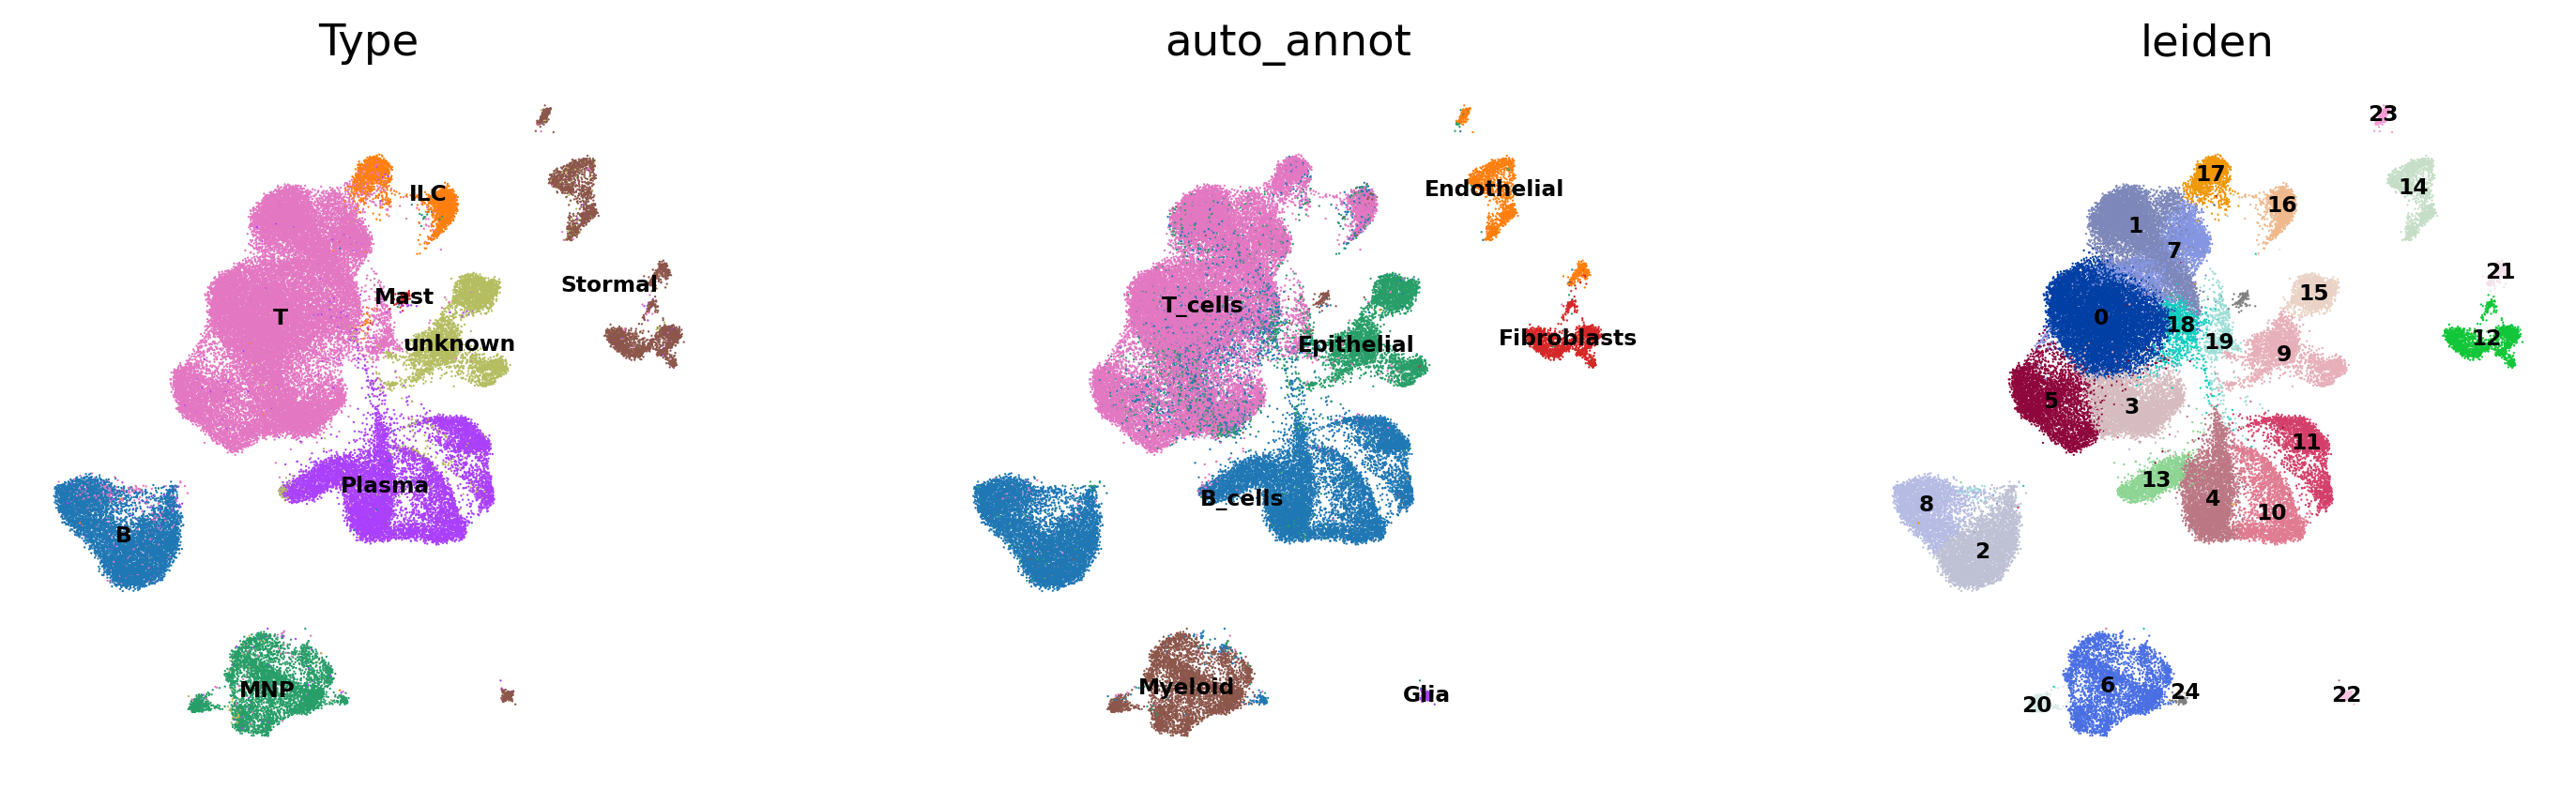

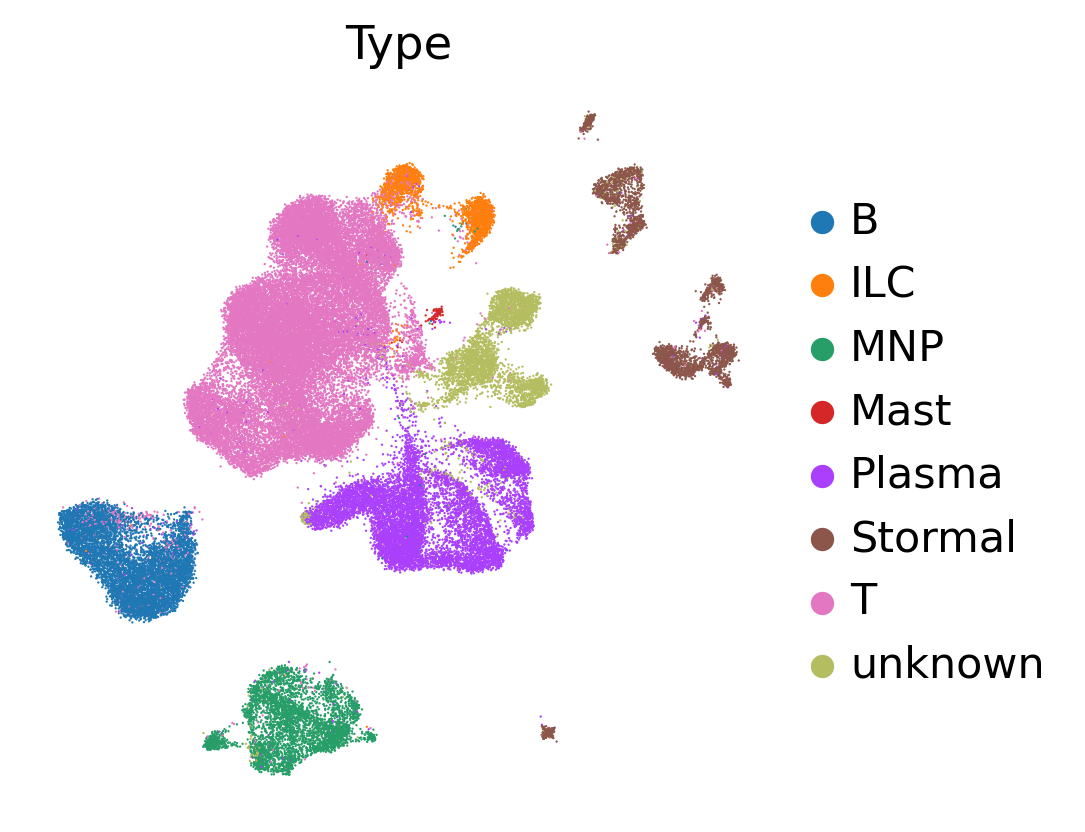

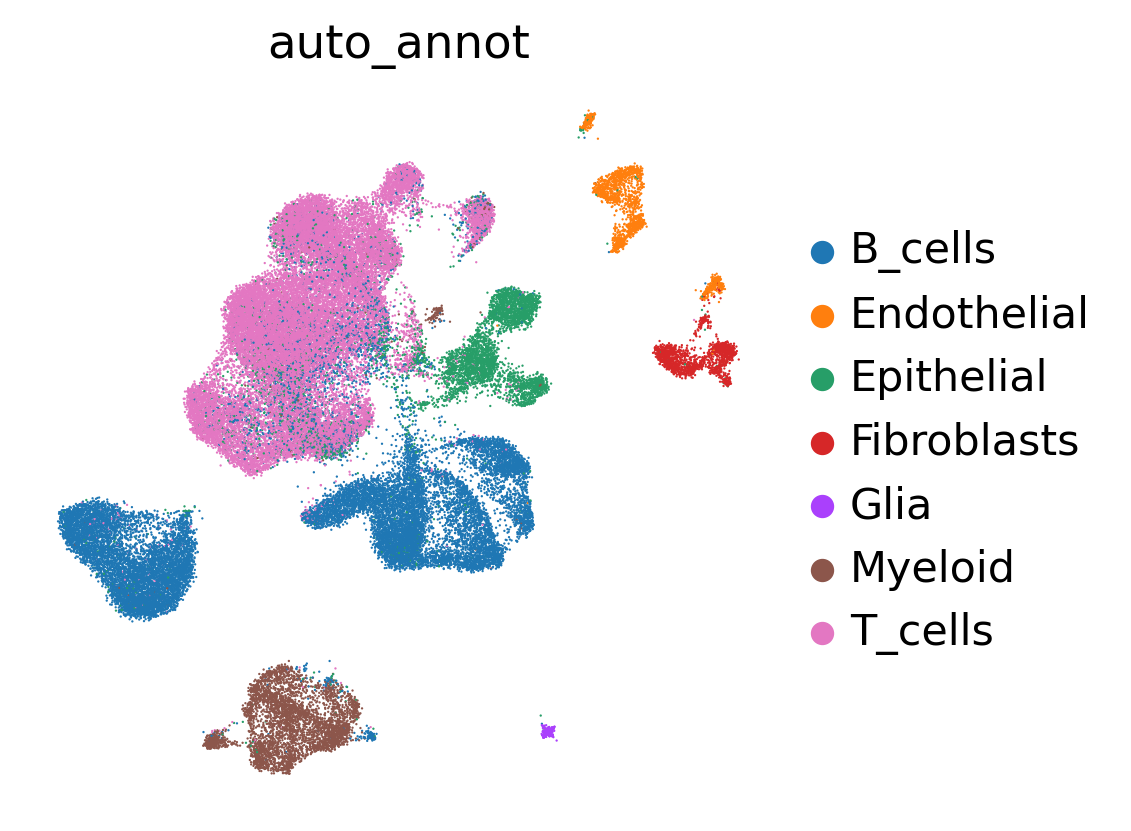

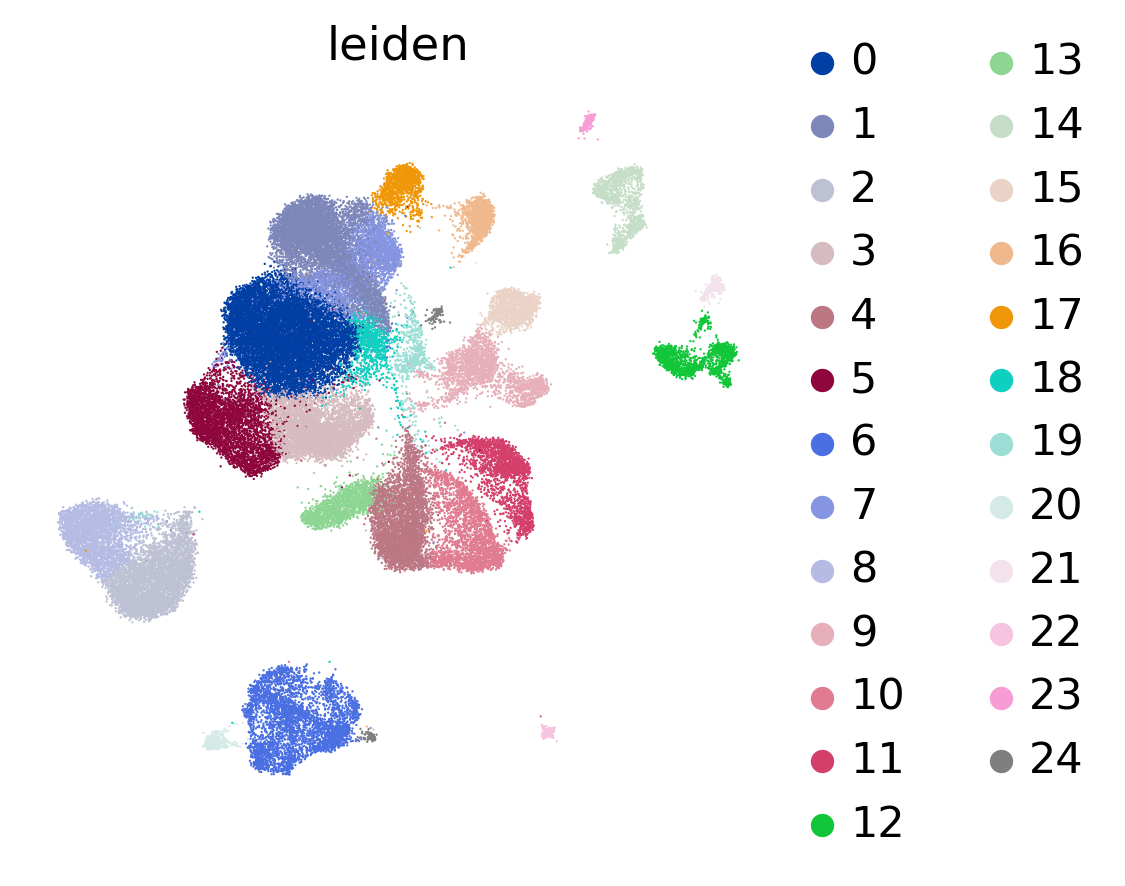

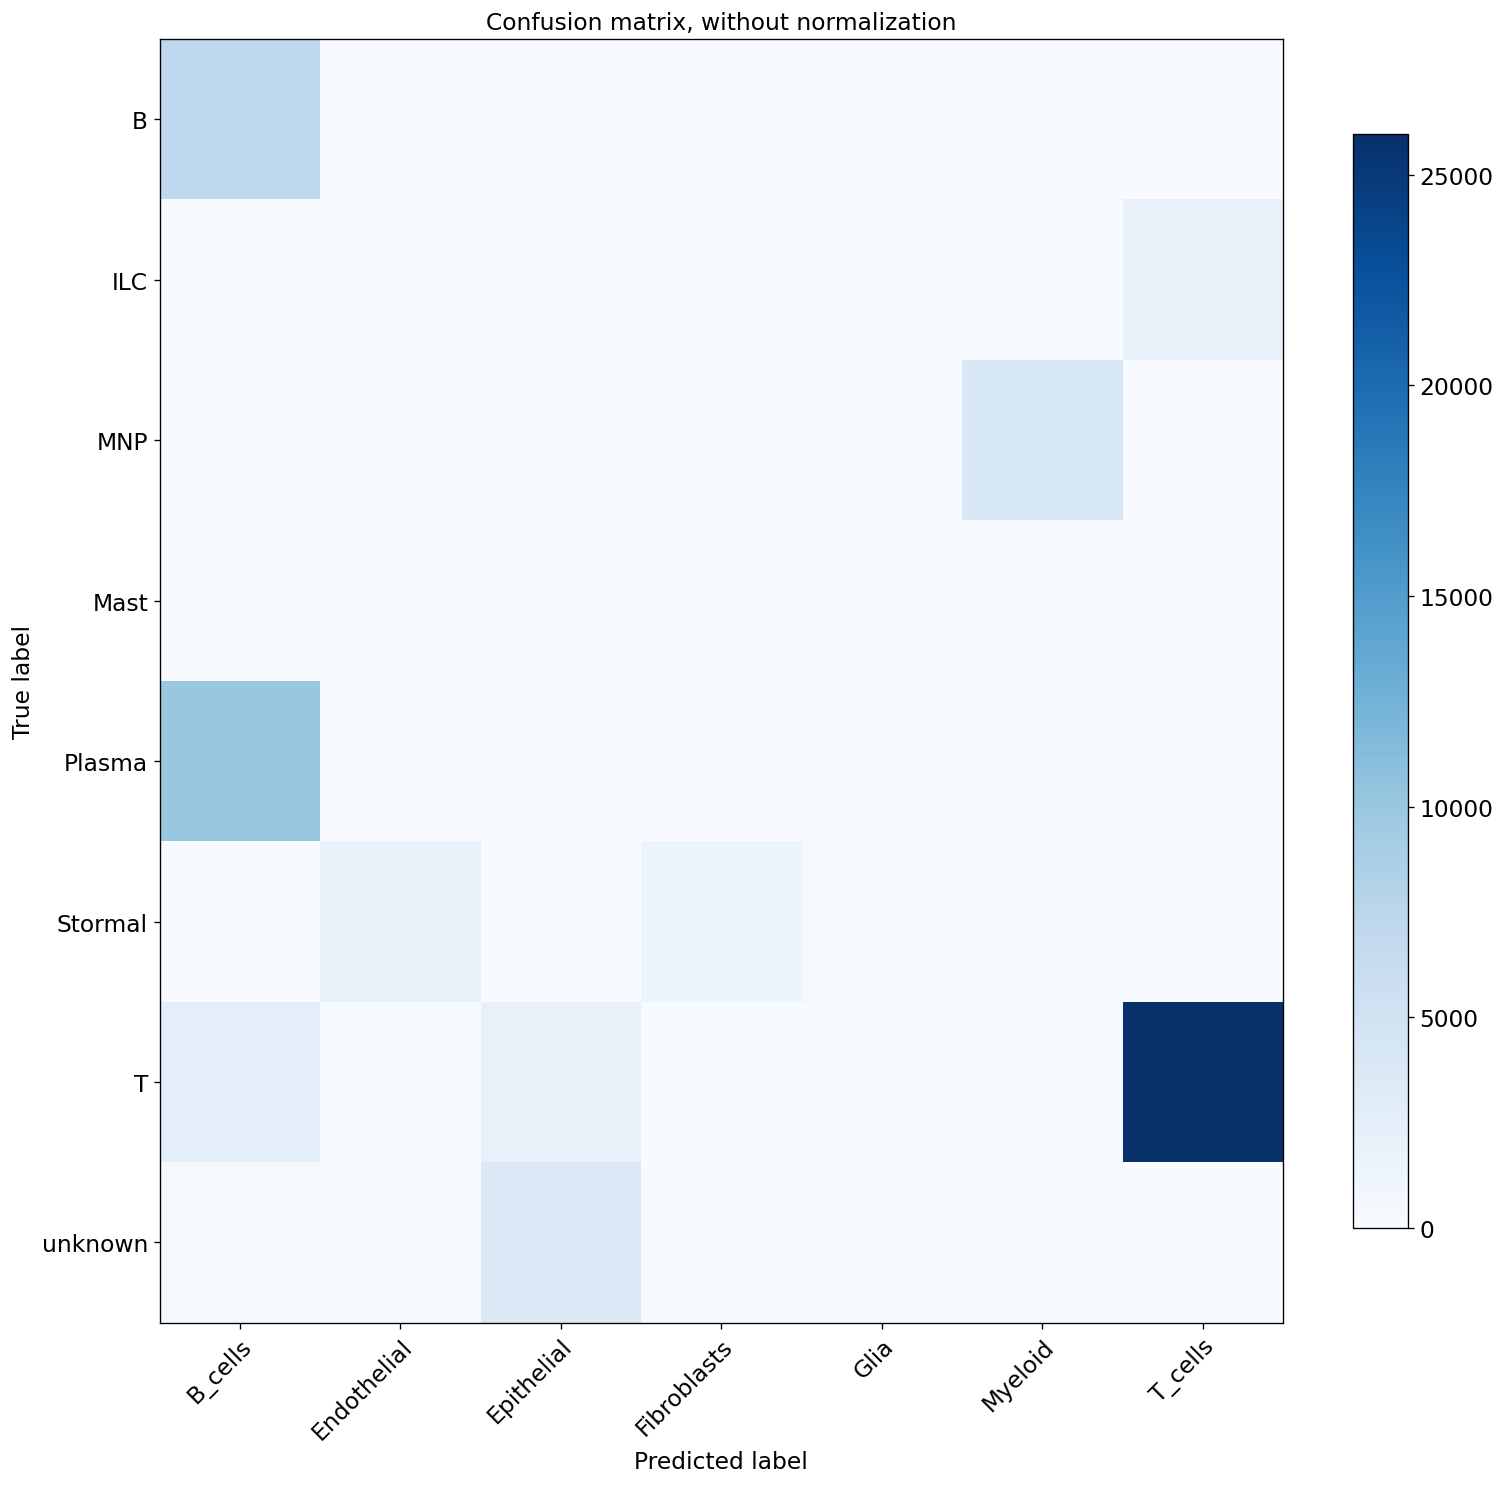

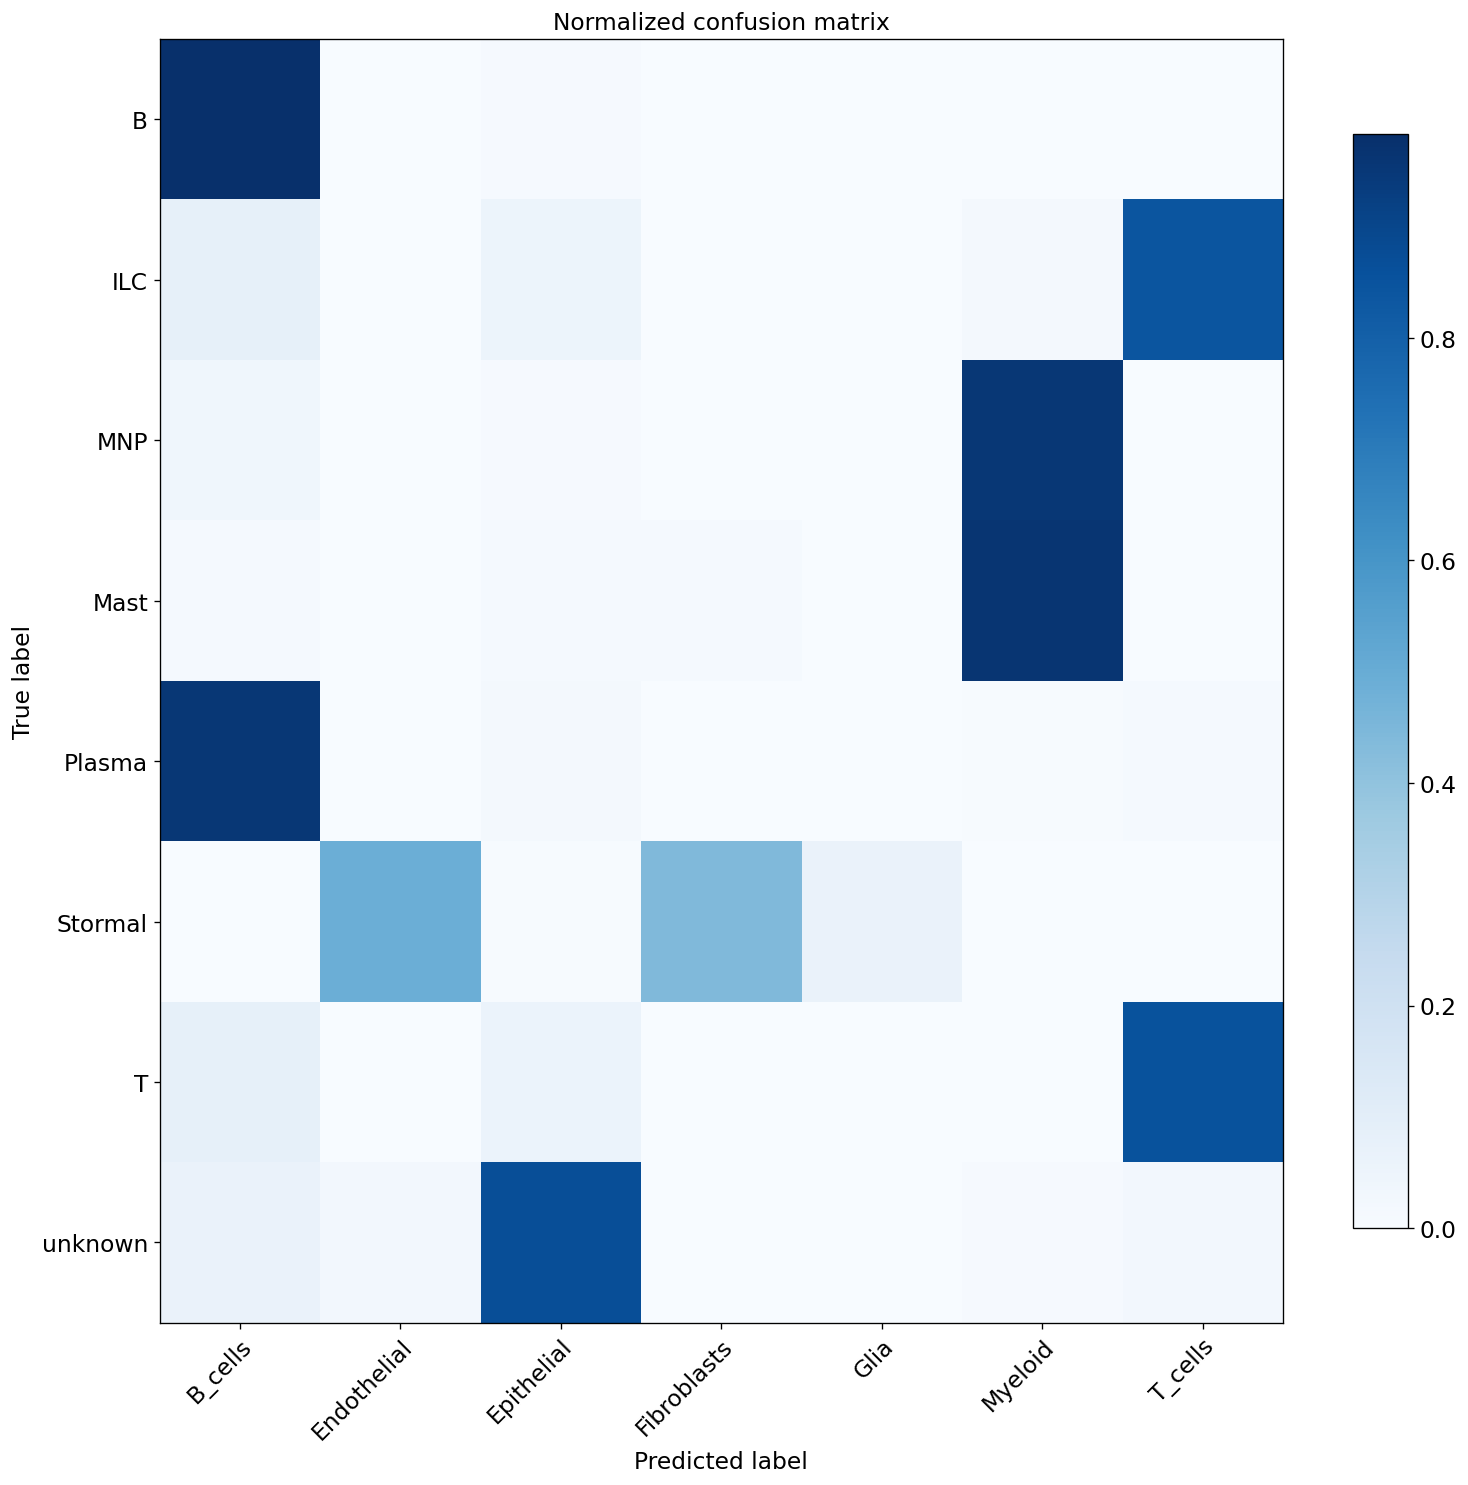

In [16]:
bc.tl.report(
    adata_pred=adata_predicted,
    celltype=celltype, 
    method=method, 
    analysis_name=analysis_name,
    train_datasets = adata_trains,
    test_dataset = adata_orig,
    merge = merge,
    name_prediction='auto_annot', 
    name_report='auto_annot', 
    use_raw=use_raw,
    remove_nonshared=False, 
    clustering='leiden', 
    asymmetric_matrix=True, 
    delimiter='\t', 
    verbose=True
)

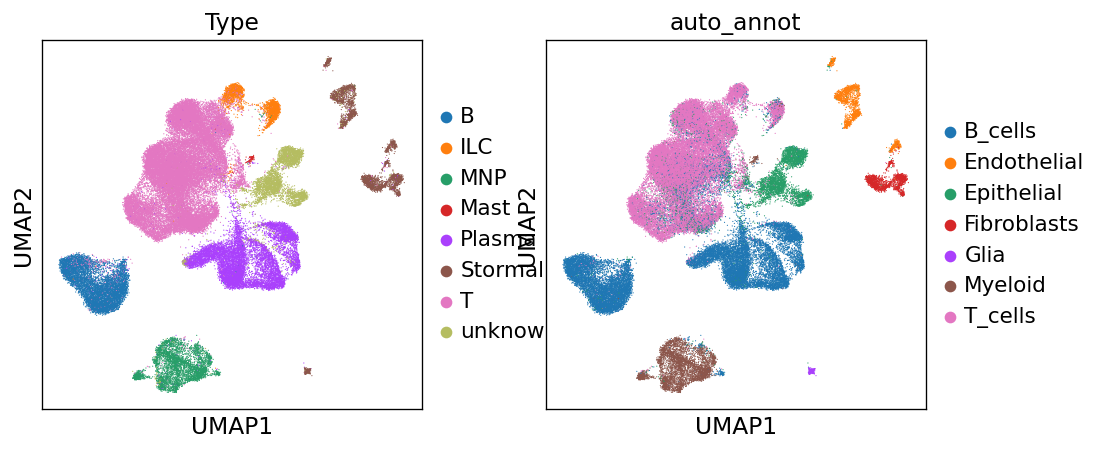

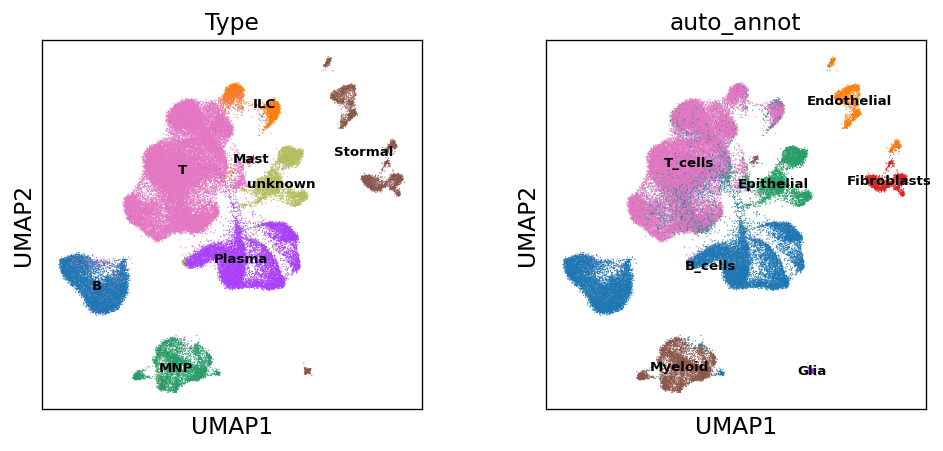

In [17]:
sc.pl.umap(adata_predicted, color=[celltype, 'auto_annot'])
sc.pl.umap(adata_predicted, color=[celltype, 'auto_annot'], legend_loc='on data', legend_fontsize=8)

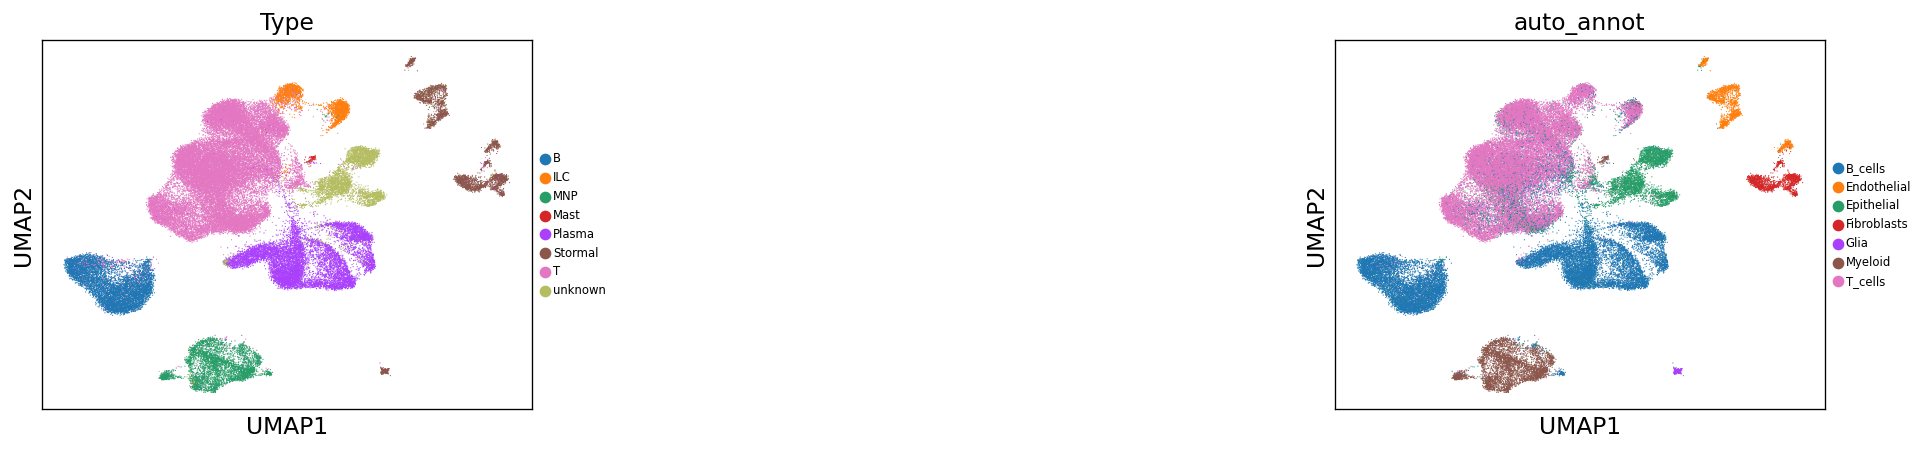

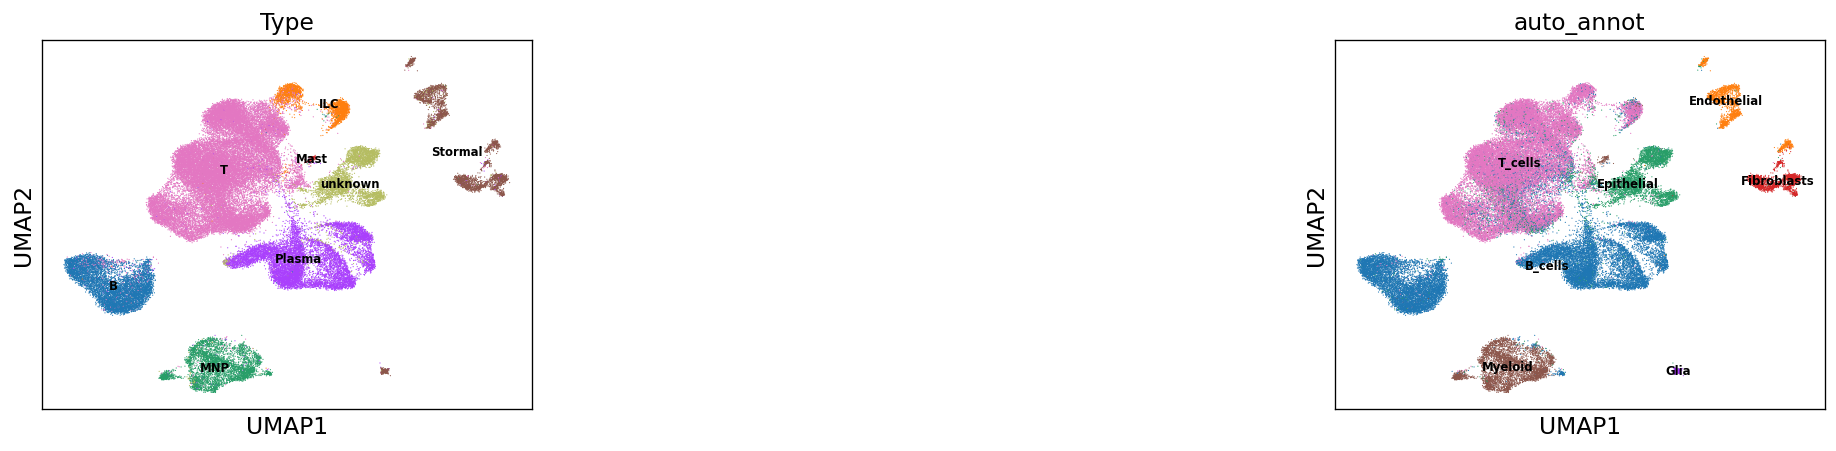

In [18]:
sc.pl.umap(adata_predicted, color=[celltype, 'auto_annot'], legend_fontsize=7, wspace = 1.4, save = '.svg')
sc.pl.umap(adata_predicted, color=[celltype, 'auto_annot'], legend_loc='on data', legend_fontsize=7, wspace = 1.4, save = '.ondata.svg')

In [19]:
adata_train

View of AnnData object with n_obs × n_vars = 149732 × 1054
    obs: 'CELL', 'Cluster', 'Health', 'Location', 'Subject', 'celltype_highlevel', 'nGene', 'nUMI', 'original_name', 'percent_mito', 'n_counts', 'n_genes', 'batch', 'leiden', 'dblabel', 'celltype', 'cluster_celltype', 'Type'
    var: 'SYMBOL', 'ENSEMBL-0', 'n_cells-0', 'total_counts-0', 'frac_reads-0', 'ENSEMBL-1', 'n_cells-1', 'total_counts-1', 'frac_reads-1'
    uns: 'Cluster_colors', 'Location_colors', 'Type_colors', 'celltype_highlevel_colors', 'leiden', 'leiden_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'X_scanorama'

acc: 0.29
f1: 0.29
ami: 0.0
ari: -0.0
silhouette Type: 0.3
silhouette random_labeling: -0.01
pair confusion matrix:
            0          1
0  1927961510  803961446
1   803961446  333142200


... storing 'random_labeling' as categorical


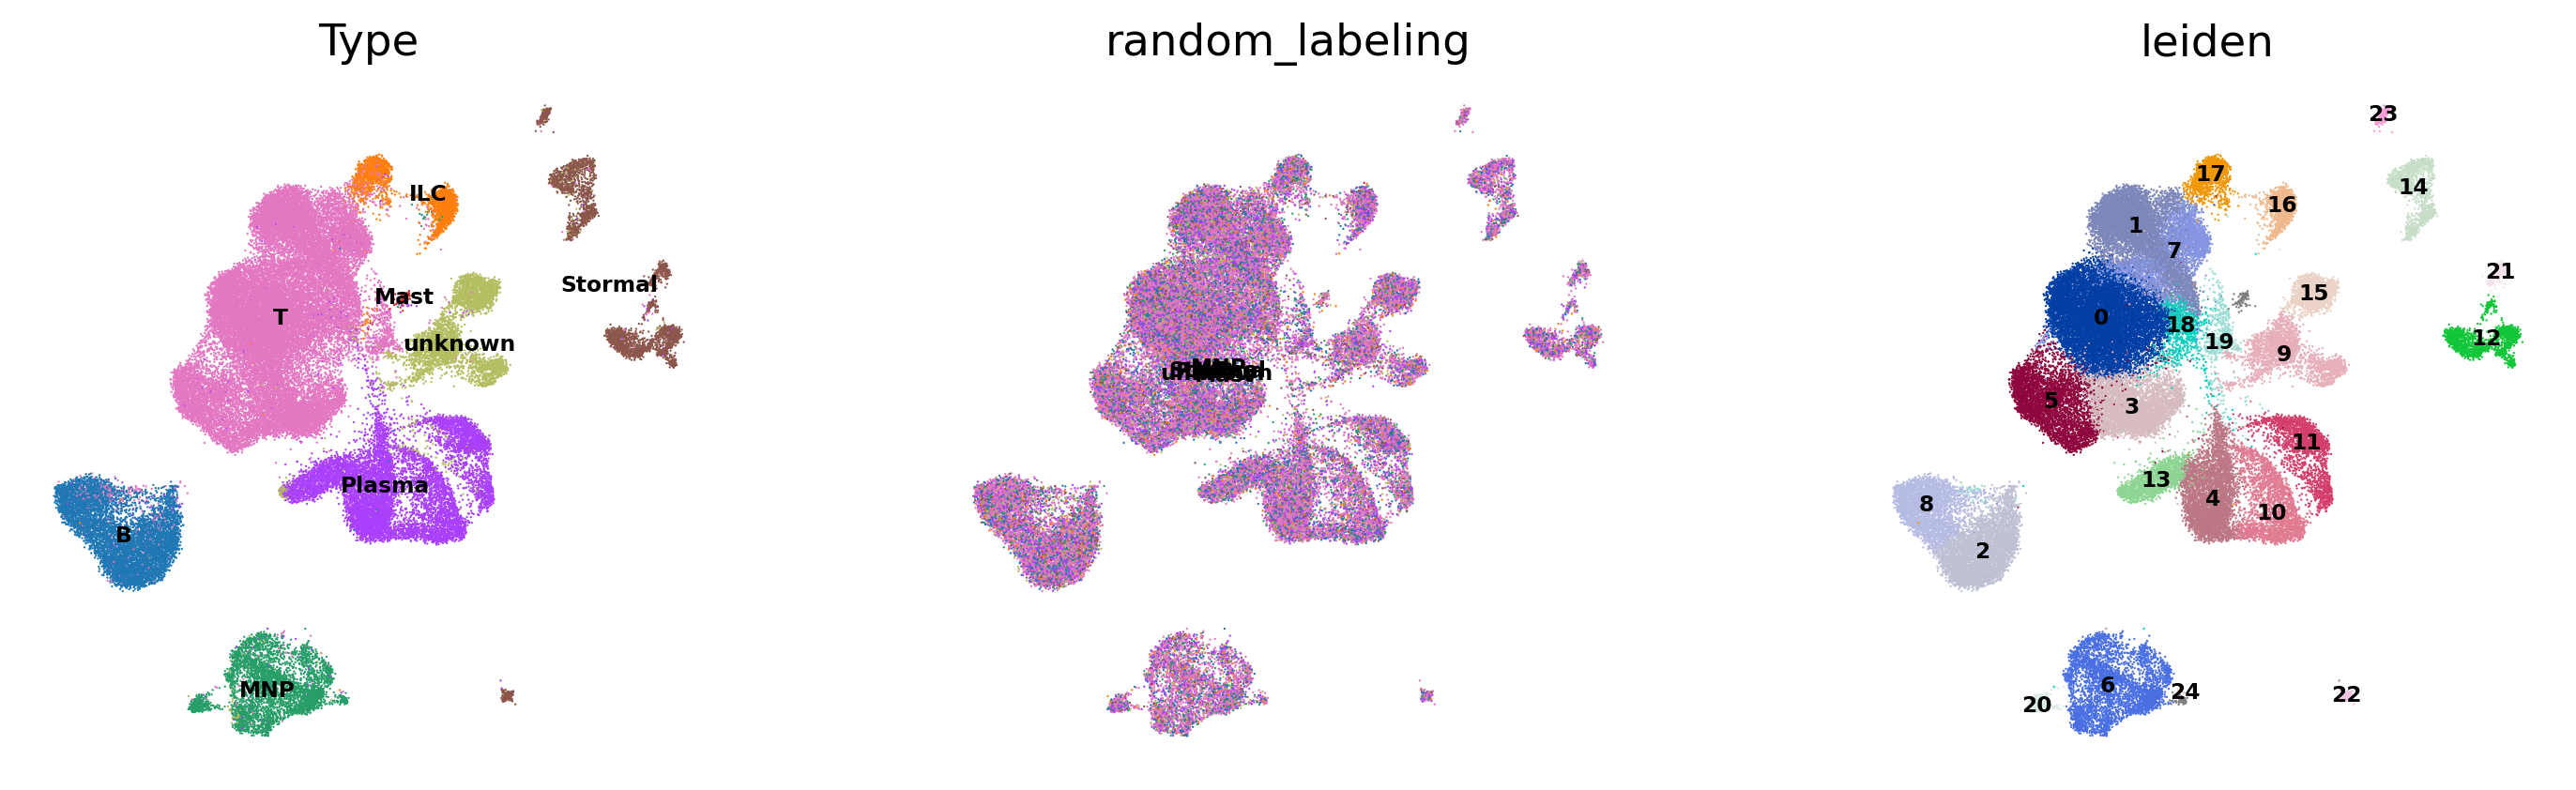

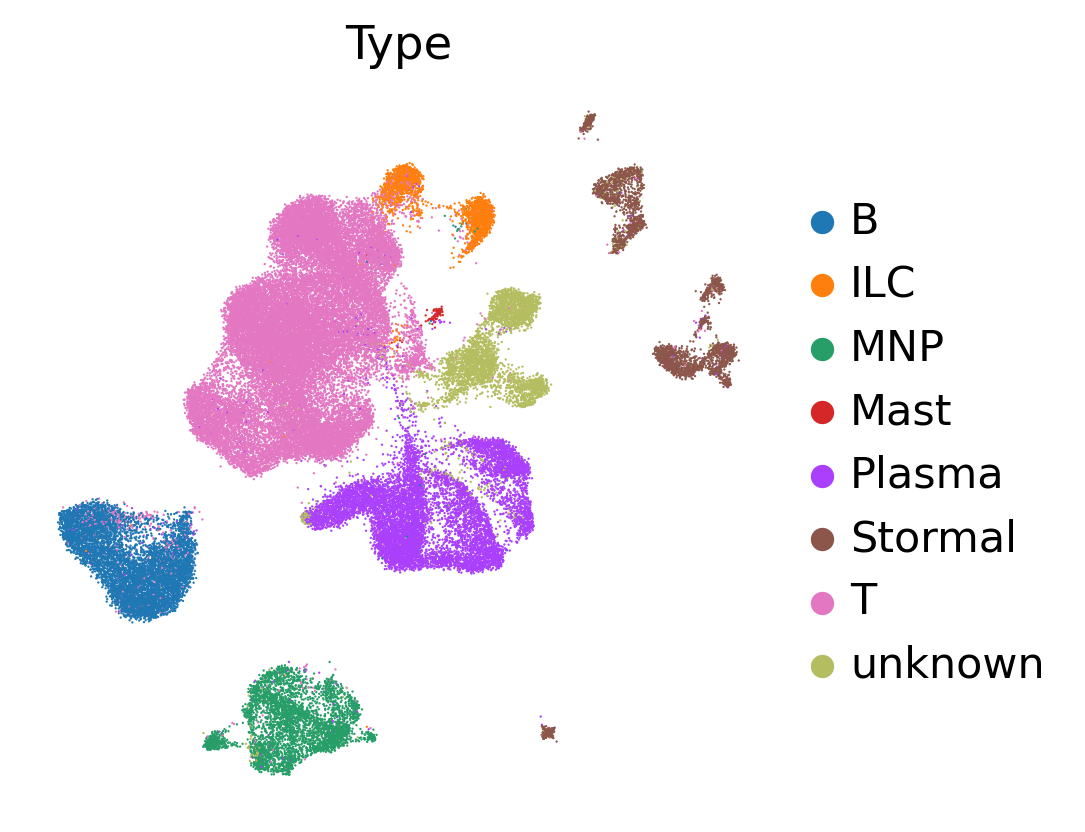

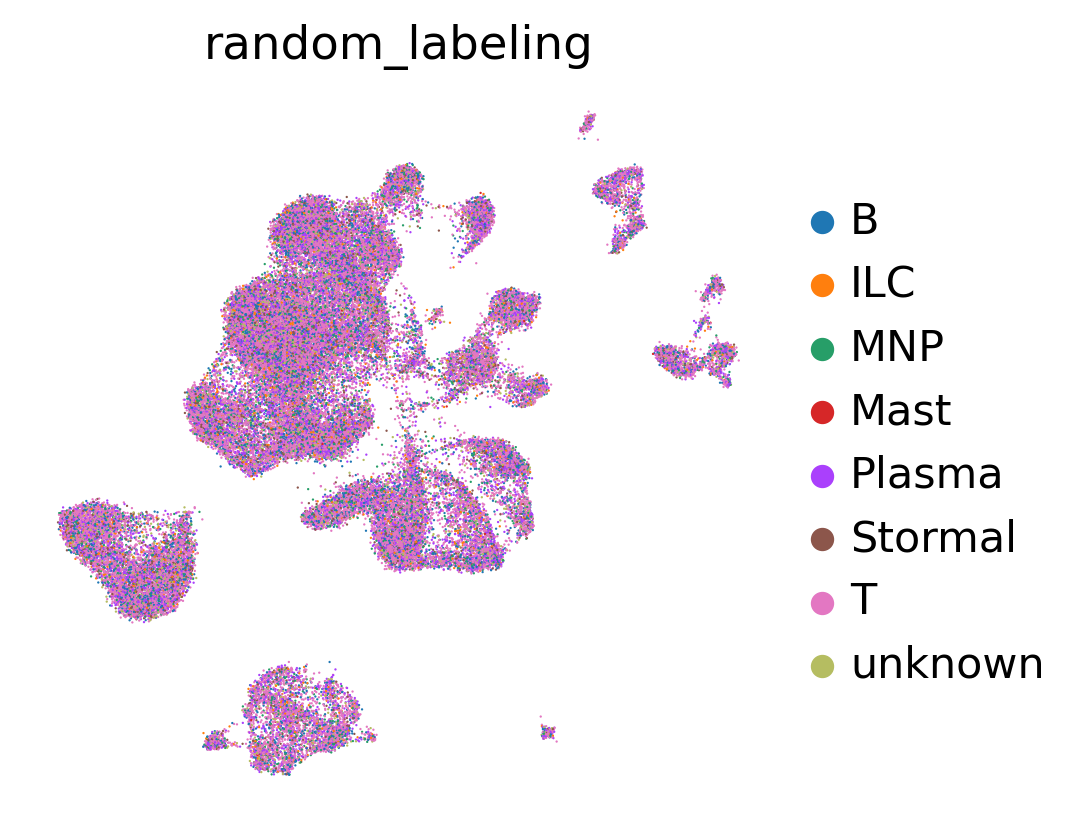

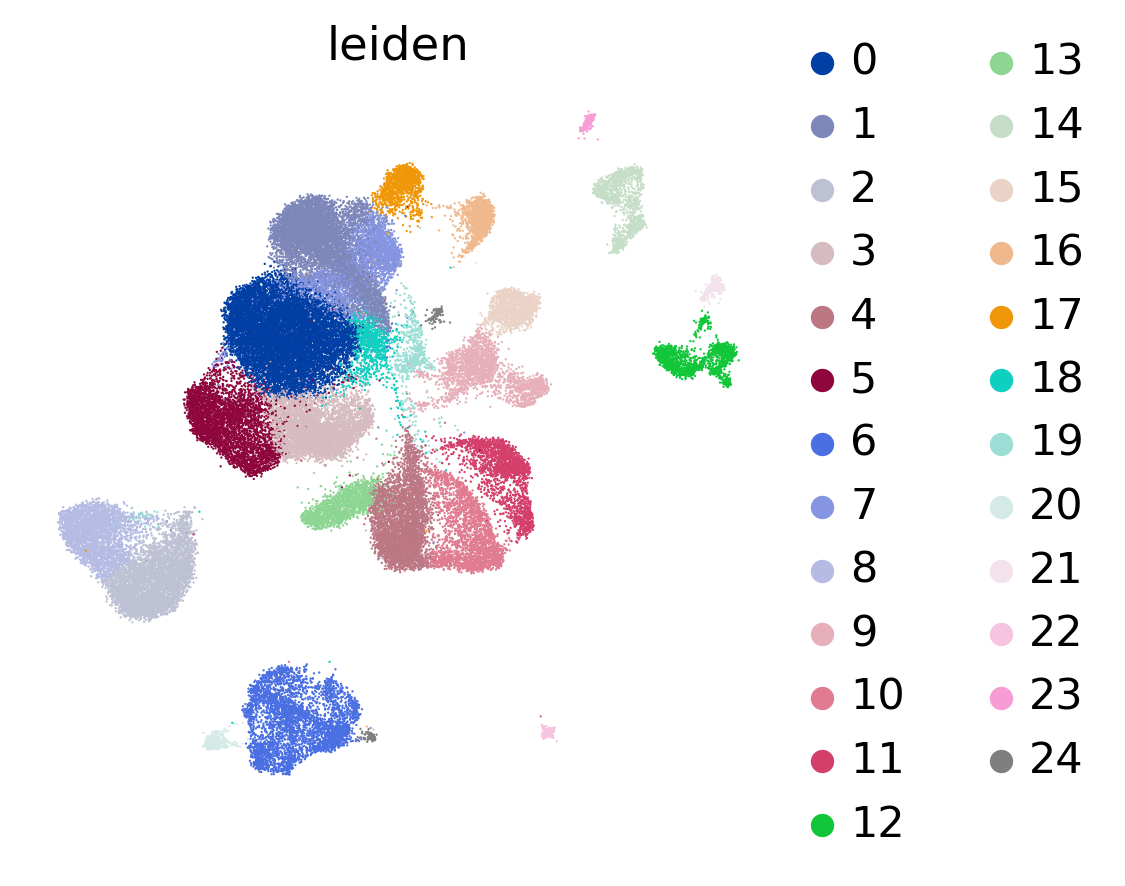

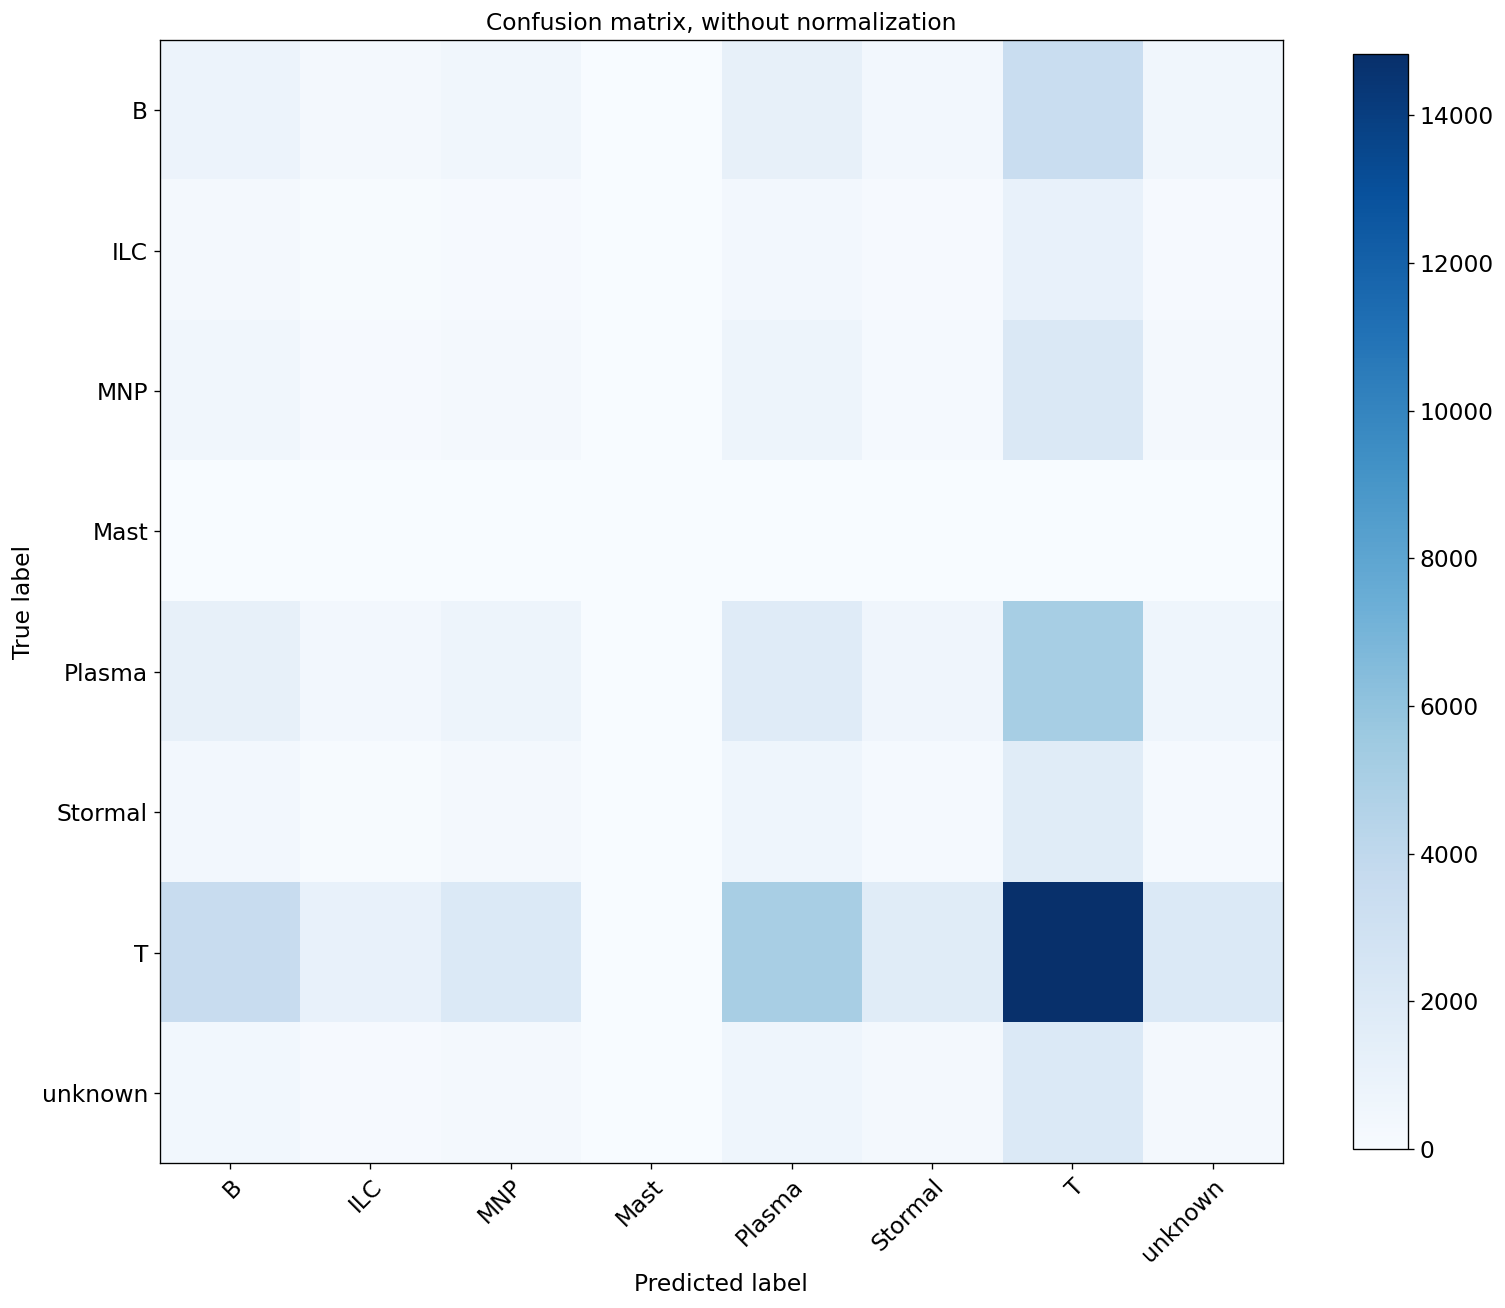

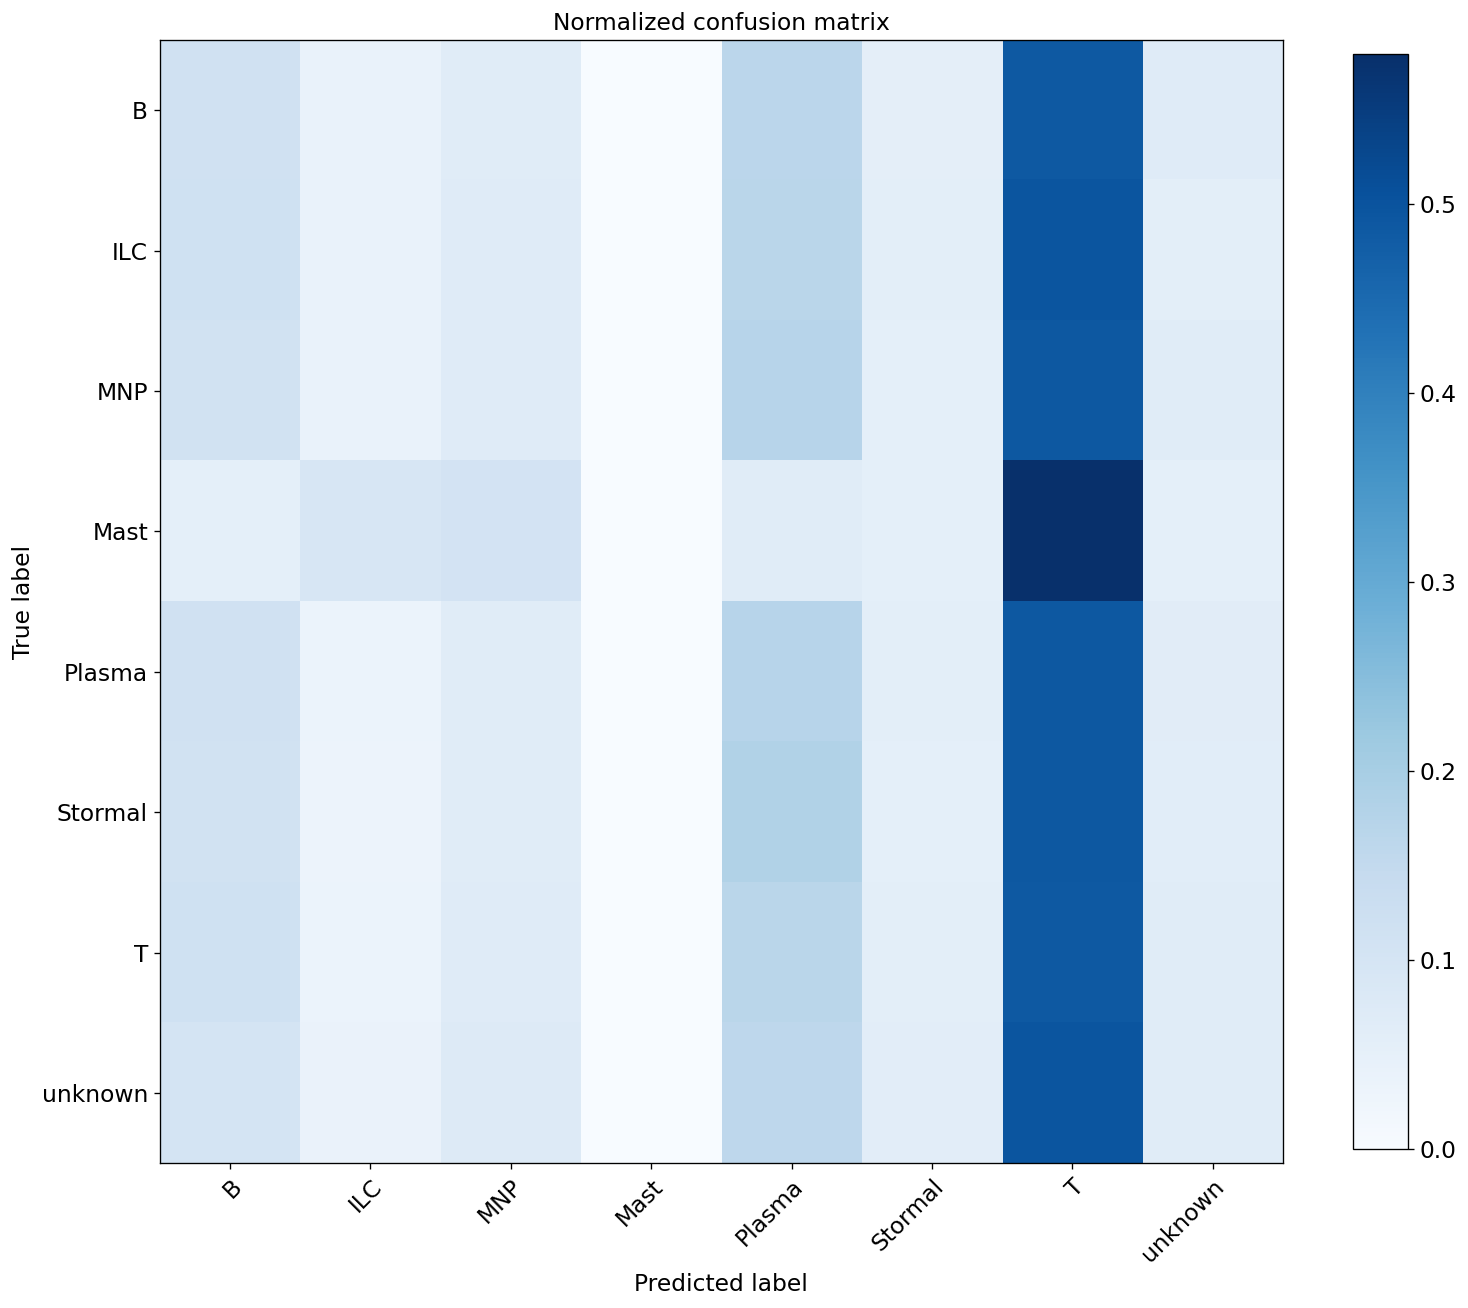

In [20]:
# Compare to random assignment
import random
random.seed(1)
adata_predicted.obs['random_labeling'] = list(adata_predicted.obs[celltype].sample(frac=1))

bc.tl.report(
    adata_pred=adata_predicted,
    celltype=celltype, 
    method="compare_to_random_" + method, 
    analysis_name=analysis_name,
    train_datasets = adata_trains,
    test_dataset = adata_orig,
    merge = merge,
    name_prediction="random_labeling",
    name_report="compare_to_random_auto_annot", 
    use_raw=use_raw,
    remove_nonshared=False, 
    clustering='leiden', 
    asymmetric_matrix=True, 
    delimiter='\t', 
    verbose=True)

In [21]:
from sinfo import sinfo
sinfo()

-----
anndata             0.7.5
besca               2.4+57.g5ad53b2
pkg_resources       NA
plotly              4.14.3
scanpy              1.6.1
sinfo               0.3.1
sklearn             0.24.1
-----
IPython             7.20.0
jupyter_client      6.1.11
jupyter_core        4.7.1
notebook            6.2.0
-----
Python 3.7.9 | packaged by conda-forge | (default, Dec  9 2020, 21:08:20) [GCC 9.3.0]
Linux-3.10.0-693.11.6.el7.x86_64-x86_64-with-centos-7.4.1708-Core
24 logical CPU cores, x86_64
-----
Session information updated at 2021-07-18 09:08
